In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

#SKLEARN
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn import linear_model, neighbors, ensemble
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, quantile_transform

#Some additional stats packages
import statsmodels.formula.api as smf
from scipy.stats import rankdata

#Charting/Display settings
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 15})
del mpl

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

In [2]:
''' This study investigates potential associations of screen time and outdoor play (as a 
proxy for physical activity) with social skills. Cross sectional data were available for 
575 mothers with a child (54% boys) aged 2–5 years in diverse neighborhoods throughout 
Melbourne. Mothers were found via ads on parenting and child education blogs, and were
instructed to report their child’s screen time, outdoor play time and social skills 
(ASBI system)'''
#https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0193700
#https://dro.deakin.edu.au/view/DU:30106962
df = pd.read_csv('stdataset.csv')
df.columns = ["ID", 'gender', 'age', 'disability', 'mothersEdu', 'allSocialSkills', 'express', 'comply', 
              'disrupt', 'meetStReqs', 'meetPhysReqs', 'screenTime', 'tvTime', 'cpuTime', 'outdoorTime']
df.disability = np.where(df.disability == 'Yes', 1, 0)
print(df.shape)
df.head()

(575, 15)


,ID,gender,age,disability,mothersEdu,allSocialSkills,express,comply,disrupt,meetStReqs,meetPhysReqs,screenTime,tvTime,cpuTime,outdoorTime
0,30208,Female,3.030801,0,3,78,38,24,12,0,0,3.000000,2.000000,1.0,1.500000
1,30400,Female,3.865845,0,3,82,39,27,10,1,1,0.000000,0.000000,0.0,4.000000
2,30863,Female,2.130048,0,3,68,35,18,11,1,0,0.857143,0.857143,0.0,1.714286
3,30530,Male,2.105407,0,3,63,29,20,12,1,0,0.500000,0.500000,0.0,1.500000
4,300057,Female,2.403833,0,3,78,38,25,11,1,0,0.357143,0.357143,0.0,1.500000


# Notes on the columns, where necessary:
- **disability**: self-reported
- **mothersEdu**: 1 means 10 years or less, 2 means 12 years or a equivalent of a trade school, and 3 means 14+ years or high education
- **allSocialSkills**: summary of the following 3 categories, all self-reported by the mother
- **express**: Mother rates their child's ability to express themself using thirteen subcategories on 3 point Likert scale. All her choices are summed
- **comply**: Mother rates their child's tendency to comply using ten subcategories on 3 point Likert scale. All her choices are summed
- **disrupt**: Mother rates their child's tendency to disrupt on seven subcategories on 3 point Likert scale. All her choices are summed
- **meetStReqs**: Whether or not this family meets the country's (AUS) screen time recommendations. this is a dichotomized version of the 3 screen time variables below
- **meetPhysReqs**: Whether or not this family meets the country's (AUS) physical activity recommendations. this is a dichotomized version of the outdoor play variable below
- **screenTime, tvTime, cpuTime, outdoorTime**: Average hours per day, reported by mother. Screentime is a sum of tvTime and cpuTime


# Data Exploration

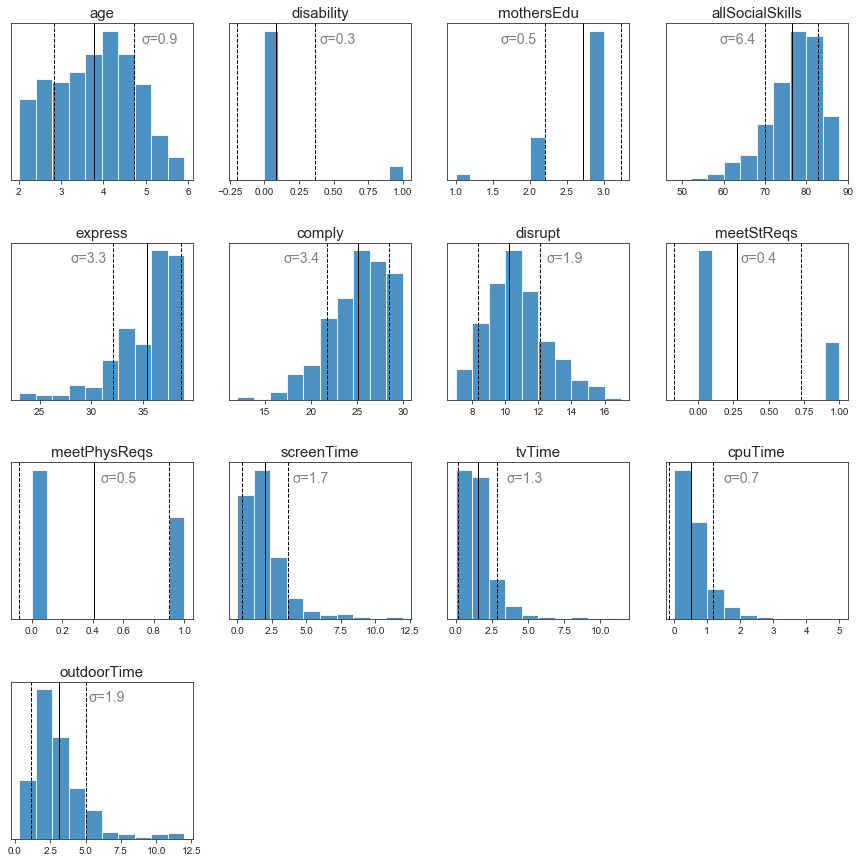

In [3]:
#Prints the distribution of all the numeric variables, including marked and annotated 
#means and standard deviations
bboxd = {'facecolor':'white', 'alpha': 0, 'edgecolor':'white'}
xdict = {'age':4.9,
         'disability':.4,
         'mothersEdu':1.6,
         'allSocialSkills':59,
         'express':28,
         'comply':17,
         'disrupt':12.5,
         'meetStReqs':.3,
         'meetPhysReqs':.45,
         'screenTime':4,
         'tvTime':3.5,
         'cpuTime':1.5,
         'outdoorTime':5.2
        }
f = plt.figure(figsize=[15,15])
for j,x in enumerate(df.columns[2:]):
    ax = f.add_subplot(4,4,j+1)
    plt.hist(df[x],alpha=.8)
    plt.axvline(df[x].mean(), color='k', linestyle='solid', linewidth=1)
    plt.axvline(df[x].mean() - df[x].std(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(df[x].mean() + df[x].std(), color='k', linestyle='dashed', linewidth=1)
    plt.yticks([])
    title = "σ="+str(round(df[x].std(),1))
    plt.text(xdict[x],np.mean(ax.get_ylim())*1.8,title,horizontalalignment='left',
                 verticalalignment='center', bbox=bboxd, fontsize=14,color='grey')
    plt.title(x, fontsize=15)
plt.subplots_adjust(hspace=.4)
plt.show()

Note that "allSocialSkills" is a calculated field that incorporates "express", "comply", and "disrupt". See [here](https://journals.sagepub.com/doi/10.1177/073428299201000303) for more information on the ASBI. 

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


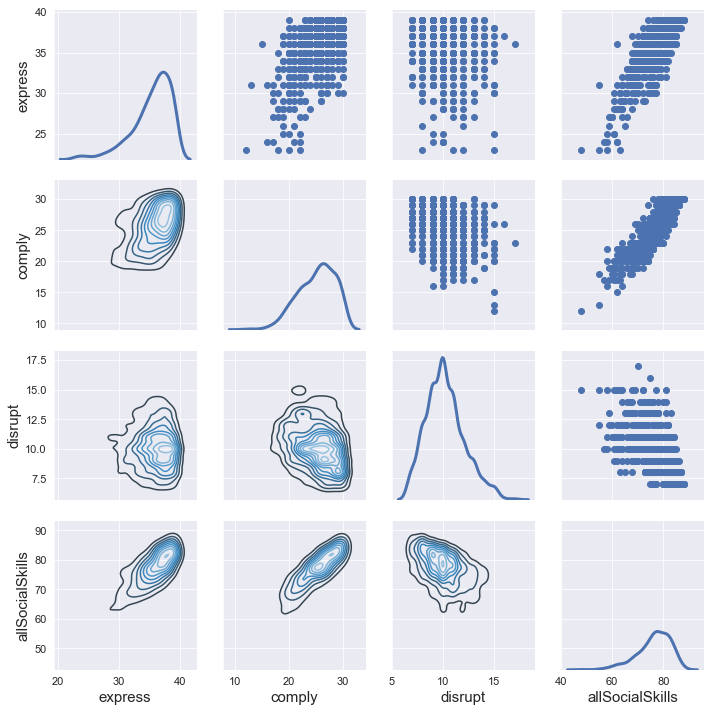

In [4]:
#Show the relationships between allSocialSkills and its 3 'input' parameters
sns.set({'axes.titlesize':15., 'axes.labelsize':15., 'xtick.labelsize': 11.0,
         'ytick.labelsize': 11.0,'legend.fontsize': 11.0})
g = sns.PairGrid(df[['express', 'comply', 'disrupt', 'allSocialSkills']])
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(sns.kdeplot, lw=3, legend=False)
plt.show()

In [5]:
#Demonstrate their relationship with a linear regression model that will be nearly perfect
regr = linear_model.LinearRegression()
x = df[['express', 'comply', 'disrupt']]
y = df.allSocialSkills
regr.fit(x,y)
scores = cross_val_score(regr,x,y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))

Fold Scores:  [0.98852157 0.99074261 0.98442617 0.99619107 0.99174191 0.99552325
 0.98661701 0.99385063 0.9916524  0.99170743]

Average Score:  0.9910974050546434


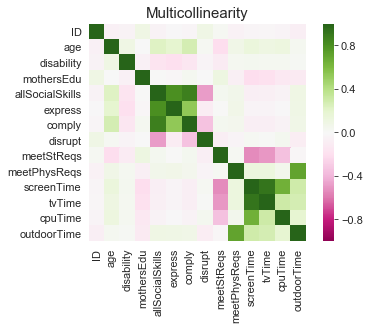

In [6]:
#View the correlations within the dataset
plt.title('Multicollinearity')
sns.heatmap(df.corr(), vmin = -1,square=True, cmap="PiYG")
plt.show()

# Can the Social Skills summary be predicted without using any of it's components - that is, using demographic and activity information?    

**Steps taken:**    
- OneHotEncode gender and mother's education
- lasso regression to see which features are useful
- linear regression and other regressor types with remaining variables

**One-Hot-Encoding**

In [7]:
df = pd.get_dummies(df, columns=['gender', 'mothersEdu'])
df.head()

,ID,age,disability,allSocialSkills,express,comply,disrupt,meetStReqs,meetPhysReqs,screenTime,tvTime,cpuTime,outdoorTime,gender_Female,gender_Male,mothersEdu_1,mothersEdu_2,mothersEdu_3
0,30208,3.030801,0,78,38,24,12,0,0,3.000000,2.000000,1.0,1.500000,1,0,0,0,1
1,30400,3.865845,0,82,39,27,10,1,1,0.000000,0.000000,0.0,4.000000,1,0,0,0,1
2,30863,2.130048,0,68,35,18,11,1,0,0.857143,0.857143,0.0,1.714286,1,0,0,0,1
3,30530,2.105407,0,63,29,20,12,1,0,0.500000,0.500000,0.0,1.500000,0,1,0,0,1
4,300057,2.403833,0,78,38,25,11,1,0,0.357143,0.357143,0.0,1.500000,1,0,0,0,1


**Feature Selection**

In [8]:
lass = linear_model.Lasso(alpha=.1)
x = df[['age', 'disability', 'meetStReqs', 'meetPhysReqs', 'tvTime',
       'cpuTime', 'outdoorTime', 'gender_Female', 'gender_Male',
       'mothersEdu_1', 'mothersEdu_2', 'mothersEdu_3']]
y = df.allSocialSkills
lass.fit(x,y)
print("Chosen coefficients (features with zero can be removed):")
display([(x.columns[i],"{0:0.2f}".format(lass.coef_[i])) for i in range(len(x.columns))])

Chosen coefficients (features with zero can be removed):


[('age', '1.66'),
 ('disability', '-2.80'),
 ('meetStReqs', '0.00'),
 ('meetPhysReqs', '-0.00'),
 ('tvTime', '-0.54'),
 ('cpuTime', '-0.28'),
 ('outdoorTime', '0.43'),
 ('gender_Female', '1.23'),
 ('gender_Male', '-0.00'),
 ('mothersEdu_1', '-0.00'),
 ('mothersEdu_2', '0.00'),
 ('mothersEdu_3', '-0.00')]

I had expected mother's education to play a larger role, let's see how those distributions look:

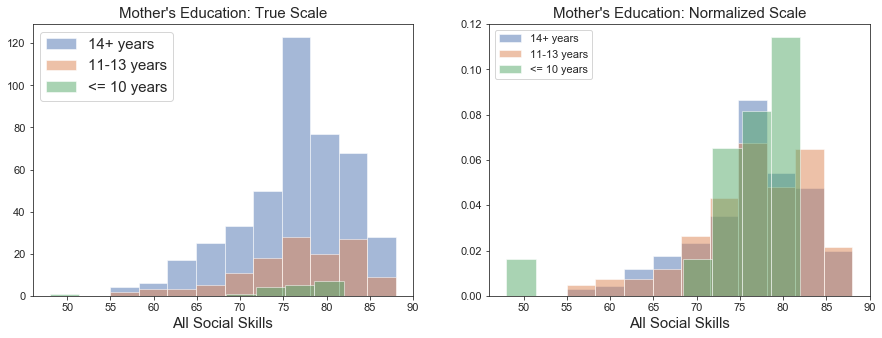

In [9]:
#Print the distribution of our target variable, allSocialSkills,
#with each 'mothersEdu' value in a different color. If truly don't
#contain meaningful information, we expect the distributions to
#overlap significantly
sns.set_style("white")
sns.set_style("ticks")
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.title('Mother\'s Education: True Scale')
plt.xlabel('All Social Skills')
plt.hist(df[df.mothersEdu_3==1]['allSocialSkills'], alpha=.5, label='14+ years')
plt.hist(df[df.mothersEdu_2==1]['allSocialSkills'], alpha=.5, label='11-13 years')
plt.hist(df[df.mothersEdu_1==1]['allSocialSkills'], alpha=.5, label='<= 10 years')
plt.legend(fontsize=15)
plt.subplot(122)
plt.title('Mother\'s Education: Normalized Scale')
plt.hist(df[df.mothersEdu_3==1]['allSocialSkills'], alpha=.5, label='14+ years', density=True)
plt.hist(df[df.mothersEdu_2==1]['allSocialSkills'], alpha=.5, label='11-13 years', density=True)
plt.hist(df[df.mothersEdu_1==1]['allSocialSkills'], alpha=.5, label='<= 10 years', density=True)
plt.xlabel('All Social Skills')
plt.legend()
plt.show()

**Linear Regression**

In [10]:
regr = linear_model.LinearRegression()
x = df[['age', 'disability', 'tvTime', 'cpuTime', 'outdoorTime', 'gender_Female']]
y = df.allSocialSkills
regr.fit(x,y)
regr.score(x,y)

0.13239561664665211

In [11]:
#Replicate in statsmodels for additional analysis
linear_formula = 'allSocialSkills ~ age+disability+tvTime+cpuTime+outdoorTime+gender_Female'
lm = smf.ols(formula=linear_formula, data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        allSocialSkills   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     14.45
Date:                Tue, 22 Jan 2019   Prob (F-statistic):           2.28e-15
Time:                        17:33:01   Log-Likelihood:                -1843.6
No. Observations:                 575   AIC:                             3701.
Df Residuals:                     568   BIC:                             3732.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        68.8026      1.137     60.524      0.000      66.570      71.035
age               1.8390      0.269      6.834      0.000       1.310       2.368
disability       -4.0338      0.899     -4.489      0.000      -5.799      -2.269
tvTime           -0.6026      0.205     -2.945      0.003      -1.005      -0.201
cpuTime          -0.5011      0.401     -1.250      0.212      -1.288       0.286
outdoorTime       0.4907      0.136      3.596      0.000       0.223       0.759
gender_Female     1.5896      0.511      3.113      0.002       0.587       2.593
==============================================================================
Omnibus:                       43.063   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.024
Skew:                          -0.683   Prob(JB):                     8.32e-12
Kurtosis:                       3.514   Cond. No.                         25.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The features selected by lasso regression are mostly intuitive: age and disability both have a strong impact on social development, girls develop social skills faster than boys, and the measured activities also are theorized to impact social development. Other Notes:
- The accuracy (adj R^2 = 12.3%) is quite poor, indicating that these are not the best predictors.
- The P-values indicate these results are probably not random except for cputTime, which is inconclusive and may just be noise. 

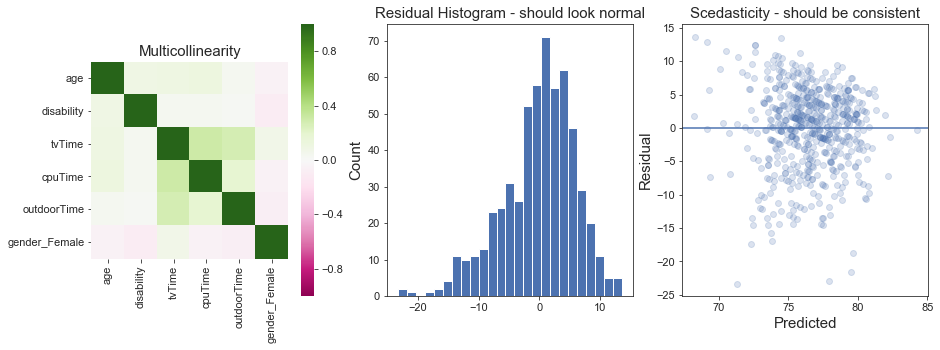

In [12]:
#Further examining our output through the lens of 
#linear regressions key assumptions: low multicolinearity,
#normally distributed residuals, and consistent scedasticity
x = df[['age', 'disability', 'tvTime',
       'cpuTime', 'outdoorTime', 'gender_Female']]

regr.fit(x,y)
pred = cross_val_predict(regr,x,y,cv=5)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.title('Multicollinearity')
sns.heatmap(x.corr(), vmin = -1,square=True, cmap="PiYG")
plt.subplot(132)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

- Lasso did a good job choosing mostly uncorrelated features.
- The Residual histogram is slightly skewed, inheriting the skew we saw in the target variable itself
- The scedasticity chart is not perfect, showing larger residuals in the long left tail of the target variable, and smaller residuals to the right.

# A Quartile transform to normalize the dependent variable improves the scedasticity and residual imbalances, but at the expense of 1% of variance explanation

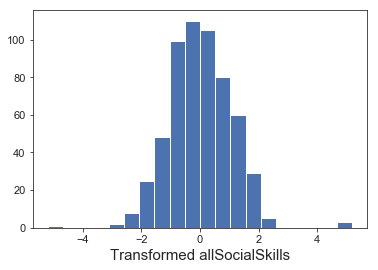

In [13]:
#Transform allSocialSkills to a normal distribution using sklearn's quantile transform
y_trans = quantile_transform(pd.DataFrame(df.allSocialSkills),output_distribution='normal').squeeze()
df['ytrans'] = y_trans
plt.hist(df.ytrans, bins=20)
plt.xlabel('Transformed allSocialSkills')
plt.show()

In [14]:
linear_formula = 'ytrans ~ age+disability+tvTime+cpuTime+outdoorTime+gender_Female'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ytrans   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     13.87
Date:                Tue, 22 Jan 2019   Prob (F-statistic):           9.59e-15
Time:                        17:33:02   Log-Likelihood:                -811.75
No. Observations:                 575   AIC:                             1638.
Df Residuals:                     568   BIC:                             1668.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.3245      0.189     -7.010      0.000      -1.696      -0.953
age               0.3180      0.045      7.110      0.000       0.230       0.406
disability       -0.5579      0.149     -3.736      0.000      -0.851      -0.265
tvTime           -0.0951      0.034     -2.796      0.005      -0.162      -0.028
cpuTime          -0.0968      0.067     -1.453      0.147      -0.228       0.034
outdoorTime       0.0882      0.023      3.888      0.000       0.044       0.133
gender_Female     0.2185      0.085      2.575      0.010       0.052       0.385
==============================================================================
Omnibus:                       59.963   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.371
Skew:                           0.445   Prob(JB):                     1.87e-44
Kurtosis:                       5.759   Cond. No.                         25.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

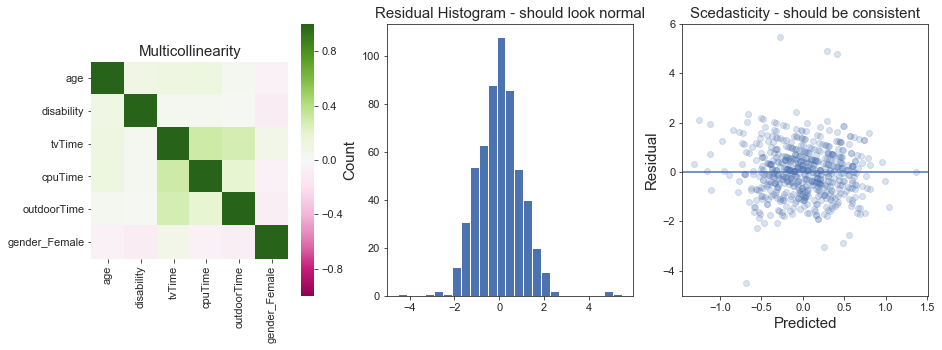

In [15]:
y = df.ytrans
regr.fit(x,y)
pred = cross_val_predict(regr,x,y,cv=5)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.title('Multicollinearity')
sns.heatmap(x.corr(), vmin = -1,square=True, cmap="PiYG")
plt.subplot(132)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()


We are now more aligned to linear regression's assumptions, but our model has lost to ability to explain variance in the process.

Overall, this data does not seem to contain a meaningful way of predicting social skills, but just in case...
# Let's see if other Regressor Types can do better:

In [16]:
#Create test/train splits
x = df[['age', 'disability', 'tvTime', 'cpuTime', 'outdoorTime', 'gender_Female']]
y=df.allSocialSkills
trainx, testx, trainy, testy = train_test_split(x,y, test_size=.5)

In [17]:
def score_model(model, test_features, test_target):
    print('Model Performance')
    print(model.score(test_features,test_target))
    print('---')

**Random Forest Regressor gridsearch**

In [18]:
#Define the parameters we want to cycle through
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 3, 5, 10],
    'max_features': [2, 'auto'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 200, 300]
}

In [19]:
rfr = ensemble.RandomForestRegressor()
gs = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=3, n_jobs=-1)

#Fit the grid search to data:
gs.fit(trainx, trainy)

#Let's see what came out best:
gs.best_params_

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True,
 'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

Using the Randomized Search CV, we can find the general range of parameters that  perform best, in this case raising R^2 scores as seen in the below comparison:

In [20]:
base_rfr = ensemble.RandomForestRegressor(n_estimators=10)
base_rfr.fit(trainx,trainy)
score_model(base_rfr,testx,testy)
best_gs = gs.best_estimator_
score_model(best_gs, testx,testy)

Model Performance
-0.03837034298700437
---
Model Performance
0.036797900145078444
---


Despite the above returning an ideal model, test data is performing significantly worse than training data. the Cross Validation built in to the grid search may be insufficient to prevent overfitting with so few samples. To dig deeper, let's isolate the depth of the trees as seen below:

In [21]:
rfr = ensemble.RandomForestRegressor(n_estimators=100,bootstrap=True,max_features=2,
                                     min_samples_leaf=3,min_samples_split=4,)

#Limit everything except n_estimators to the best param identified in the last grid search
param_grid = {
    'max_depth': [2,3,4,5,6,7,8,9,10]
}
gst = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=5, n_jobs=-1)

#Fit the grid search to data:
gst.fit(trainx, trainy)


# Extract information from the cross validation model
train_scores = gst.cv_results_['mean_train_score']
test_scores = gst.cv_results_['mean_test_score']
param_values = list(gst.cv_results_['param_max_depth'])
train_time = gst.cv_results_['mean_fit_time']

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


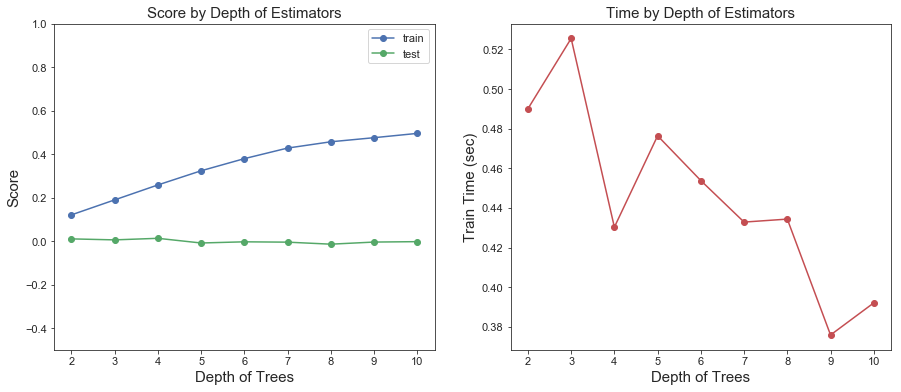

In [22]:
# Plot the scores over the parameter

plt.subplots(1, 2, figsize=(15, 6))
plt.subplot(121)
plt.plot(param_values, train_scores, 'bo-', label = 'train')
plt.plot(param_values, test_scores, 'go-', label = 'test')
plt.legend()
plt.xlabel('Depth of Trees')
plt.ylabel('Score')
plt.title('Score by Depth of Estimators')
plt.ylim([-.5,1])

plt.subplot(122)
plt.plot(param_values, train_time, 'ro-')

plt.title('Time by Depth of Estimators')
plt.ylabel('Train Time (sec)')
plt.xlabel('Depth of Trees')


plt.show()

Random Forest isn't beating simple linear regression.

**KNN Regressor**

In [23]:
#Define the parameters we want to cycle through
param_grid = {
    'n_neighbors': [2,5,10,30,50,75],
    'weights' : ['uniform', 'distance']
}

In [24]:
knnr = neighbors.KNeighborsRegressor()
knngs = GridSearchCV(estimator=knnr, param_grid=param_grid,cv=5, n_jobs=-1)

#Fit the grid search to data:
knngs.fit(trainx, trainy)

#Let's see what came out best:
knngs.best_params_

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 75, 'weights': 'distance'}

Plot the change in accuracy as we increase neighbors using distance weighting:

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


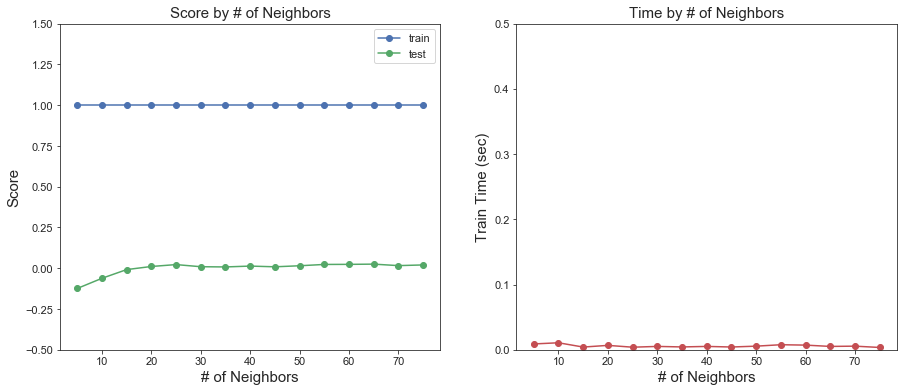

In [25]:
knnr = neighbors.KNeighborsRegressor(weights='distance')

param_grid = {
    'n_neighbors': [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
}
knngs = GridSearchCV(estimator=knnr, param_grid=param_grid,cv=5, n_jobs=-1)

#Fit the grid search to data:
knngs.fit(trainx, trainy)


# Extract information from the cross validation model
train_scores = knngs.cv_results_['mean_train_score']
test_scores = knngs.cv_results_['mean_test_score']
param_values = list(knngs.cv_results_['param_n_neighbors'])
train_time = knngs.cv_results_['mean_fit_time']

# Plot the scores over the parameter
plt.subplots(1, 2, figsize=(15, 6))
plt.subplot(121)
plt.plot(param_values, train_scores, 'bo-', label = 'train')
plt.plot(param_values, test_scores, 'go-', label = 'test')
plt.legend()
plt.xlabel('# of Neighbors')
plt.ylabel('Score')
plt.title('Score by # of Neighbors')
plt.ylim([-.5,1.5])

plt.subplot(122)
plt.plot(param_values, train_time, 'ro-')
plt.xlabel('# of Neighbors')
plt.title('Time by # of Neighbors')
plt.ylabel('Train Time (sec)')
plt.ylim([0,.5])


plt.show()

Perfect scoring on training data is to be expected when distance weighting is used, as each point will be weighted 1 to score itself. Regardless, once you get to ~20 neighbors, adding more seems to make no difference on test data accuracy. KNN is not an improvement on Random Forest or Linear Regression.

---

# Would it be possible to predict students with the worst 'disrupt' scores based on the other collected variables?

**Steps:**    
- Convert the disrupt score to a binary problem by picking a cutoff. Example: A school administration is trying to prevent classrooms from having too many disruptive students, so they are trying to identify which of their incoming students are likely to be disruptive in advance (disrupt score > x)
- Baseline - Use logistic regression on existing features to predict disruptive students 
- Feature Engineering & PCA exploration
- Final model analysis

In [26]:
#students with disrupt scores higher than this will be what we're
#searching for:
disruptScoreCutoff = 13
#here's our available features:
x = df[['age', 'disability', 'express', 'comply', 'meetStReqs', 'meetPhysReqs', 
        'screenTime', 'tvTime','cpuTime', 'outdoorTime', 'gender_Female', 
        'gender_Male','mothersEdu_1', 'mothersEdu_2', 'mothersEdu_3']]
yfull = df.disrupt
y=df.disrupt > disruptScoreCutoff
grp =pd.DataFrame(y)
grp['allDataCount'] = 1
display(grp.groupby('disrupt').agg('count'))

,allDataCount
disrupt,
False,542
True,33


In [27]:
#Function for quick analysis of Logistic Regression models

def evalClassifier(model,test_feats, test_y):
    '''This function assumes True/False are the targets and
    that outputs will thereby be ordered [False,True]
    if you're unsure, print(model.classes_)'''
    #store predicted probabilities
    proba = model.predict_proba(test_feats)
    #For the ROC curve, we only need the probability
    #of a positive outcome:
    probPos_ = [i[1] for i in proba]
    target_ = np.where(test_y==True,1,0)
    #Store the true answers along with predicted %positive for analysis
    df = pd.DataFrame({'probPos':probPos_, 'target': target_})
    #generates data for the ROC curve chart
    fpr, tpr, _ = roc_curve(test_y,proba[:,1])
    #generates an AUC score to label the ROC chart
    roc_auc = auc(fpr, tpr)
    #generates the confusion matrix array
    cm = confusion_matrix(test_y,model.predict(test_feats))
    
    plt.figure(figsize=[15,4])
    #Plot the confusion matrix, with color coordination
    #and easy labels
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 16}, fmt='g')
    labs = ['True Negatives', 'False Positives','False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + labs[i])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    
    plt.subplot(132)
    #Plot the distributions of the TRUE 2 classes, which
    #helps us understand how well our model is differentiating them
    plt.hist(df[df.target==0].probPos, density=True, alpha=.5, color='green', label='Behaved')
    plt.hist(df[df.target==1].probPos, density=True, alpha=.5, color='red',  label='Disruptive')
    plt.legend(loc="upper right")
    plt.xlim([0,1])
    plt.xlabel('Positive Probability (predicted)')
    plt.ylabel('Count (normalized scale)')
    plt.title('Distributions of Predictions')
    
    plt.subplot(133)
    #Plot the ROC curve
    plt.plot(fpr, tpr, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.subplots_adjust(wspace=.2)
    plt.show()
    #Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    return 'Model F1 Score: %0.2f' % F1

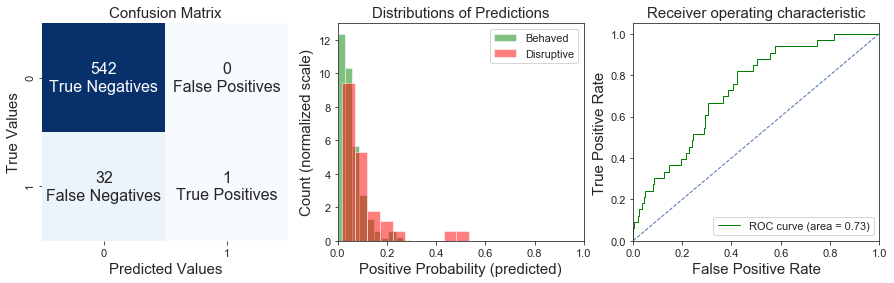

'Model F1 Score: 0.06'

In [28]:
#attempt a simple Logistic Regression model and evaluate it
lgrcv = linear_model.LogisticRegressionCV(cv=5, solver='liblinear', multi_class='ovr')
lgrcv.fit(x,y)
evalClassifier(lgrcv,x,y)

**Class imbalance seems to be preventing any progress here. Let's try with class weights:**

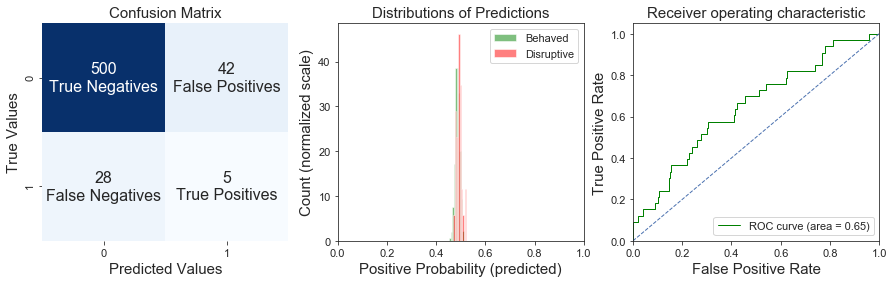

'Model F1 Score: 0.12'

In [29]:
#Logistic Regression with balanced classes
lgrcv = linear_model.LogisticRegressionCV(cv=5, solver='liblinear', multi_class='ovr', class_weight='balanced')
lgrcv.fit(x,y)
evalClassifier(lgrcv,x,y)

**That may have been an overcorrection, let's try some manual weights:**

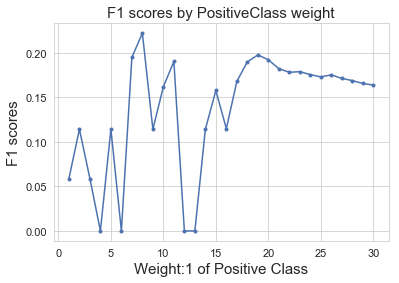

In [30]:
weights = list(range(1,31))
F1scores = []
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in weights:
        lgrcv = linear_model.LogisticRegressionCV(
            cv=5, solver='liblinear', multi_class='ovr',class_weight = {False:1,True:i})
        lgrcv.fit(x,y)
        cm = confusion_matrix(y,lgrcv.predict(x))
        tn, fp, fn, tp = [i for i in cm.ravel()]
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = 2*(precision * recall) / (precision + recall)
        if np.isnan(F1):
            F1 = 0
        F1scores.append(F1)
sns.set_style("whitegrid")
plt.plot(weights, F1scores, 'b.-')
plt.title('F1 scores by PositiveClass weight')
plt.xlabel('Weight:1 of Positive Class')
plt.ylabel('F1 scores')
plt.show()
sns.set_style("white")

Analysis: Although F1-score peaks at 7, that appears to be a volatile region. 19 is a much more stable peak, and is also closer to the true class ratio in our data (~16:1)

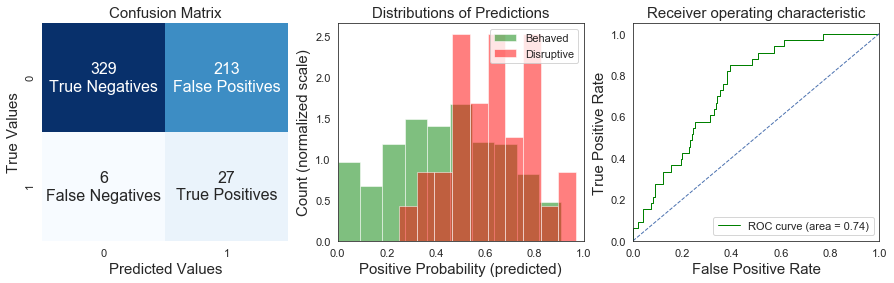

'Model F1 Score: 0.20'

In [31]:
lgrcv = linear_model.LogisticRegressionCV(cv=5, solver='liblinear', multi_class='ovr', class_weight={False:1,True:19})
lgrcv.fit(x,y)
evalClassifier(lgrcv,x,y)

At this point, we could tell the school something like this, based on the ROC curve above and choosing a decision threshold:    
*"Our current model could correctly identify ~85% of disruptive students; however, it would also result in almost 40% of well-behaved students being mistakenly labelled as disruptive".*    

This is not a useable solution: there would be way too many well behaved students being treated as disruptive. Let's dig into the features and see if we can improve this.

# Feature Analysis
Let's see if a Ridge Logistic Regression will improve things:

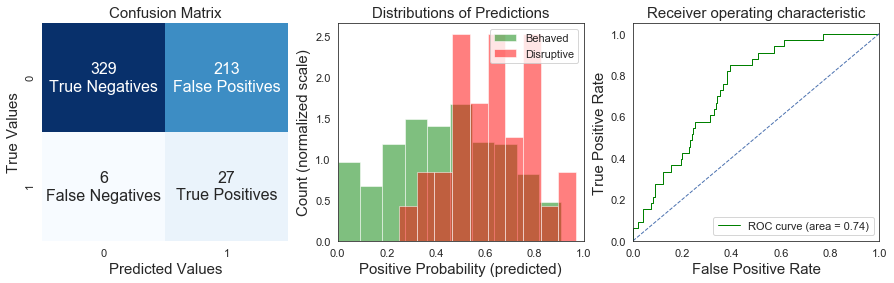

'Model F1 Score: 0.20'

In [32]:
ridgelgrcv = linear_model.LogisticRegressionCV(Cs=15, penalty='l2', cv=5, solver='liblinear',
                        multi_class='ovr', class_weight={False:1,True:19}, max_iter=200, verbose=0)
ridgelgrcv.fit(x,y)
evalClassifier(ridgelgrcv, x,y)

Ridge appears to be a net zero. Let's look at correlations:

In [33]:
#Continuous variables:
df[['disrupt', 'age', 'express', 'comply', 'tvTime', 'cpuTime', 'outdoorTime']].corr()

,disrupt,age,express,comply,tvTime,cpuTime,outdoorTime
disrupt,1.000000,0.025579,-0.094974,-0.342055,0.013433,0.040549,-0.086686
age,0.025579,1.000000,0.195447,0.276192,0.107997,0.118716,0.038923
express,-0.094974,0.195447,1.000000,0.531880,-0.034606,-0.013458,0.089873
comply,-0.342055,0.276192,0.531880,1.000000,-0.083300,-0.043947,0.078911
tvTime,0.013433,0.107997,-0.034606,-0.083300,1.000000,0.310639,0.281133
cpuTime,0.040549,0.118716,-0.013458,-0.043947,0.310639,1.000000,0.192238
outdoorTime,-0.086686,0.038923,0.089873,0.078911,0.281133,0.192238,1.000000


In [34]:
#Boolean Variables:
df[['disrupt','disability', 'meetStReqs', 'meetPhysReqs', 'gender_Female', 'gender_Male',
    'mothersEdu_1', 'mothersEdu_2', 'mothersEdu_3']].corr()

,disrupt,disability,meetStReqs,meetPhysReqs,gender_Female,gender_Male,mothersEdu_1,mothersEdu_2,mothersEdu_3
disrupt,1.000000,-0.036276,-0.077587,-0.033848,-0.016730,0.016730,0.052234,-0.038540,0.015802
disability,-0.036276,1.000000,-0.108984,0.033321,-0.098547,0.098547,0.050854,0.030491,-0.049550
meetStReqs,-0.077587,-0.108984,1.000000,0.030705,0.019774,-0.019774,-0.067050,-0.085005,0.108107
meetPhysReqs,-0.033848,0.033321,0.030705,1.000000,-0.088349,0.088349,-0.006611,0.091772,-0.084962
gender_Female,-0.016730,-0.098547,0.019774,-0.088349,1.000000,-1.000000,0.054826,0.009699,-0.031295
gender_Male,0.016730,0.098547,-0.019774,0.088349,-1.000000,1.000000,-0.054826,-0.009699,0.031295
mothersEdu_1,0.052234,0.050854,-0.067050,-0.006611,0.054826,-0.054826,1.000000,-0.095229,-0.311004
mothersEdu_2,-0.038540,0.030491,-0.085005,0.091772,0.009699,-0.009699,-0.095229,1.000000,-0.916473
mothersEdu_3,0.015802,-0.049550,0.108107,-0.084962,-0.031295,0.031295,-0.311004,-0.916473,1.000000


**PCA for the continuous variables that have some correlation**

In [35]:
df[['age', 'comply','express']].corr()

,age,comply,express
age,1.000000,0.276192,0.195447
comply,0.276192,1.000000,0.531880
express,0.195447,0.531880,1.000000


In [36]:
pcacols = df[['age', 'comply','express']].astype('float')
X = StandardScaler().fit_transform(pcacols)
eig_val_cov, eig_vec_cov = np.linalg.eig(np.cov(X.T))
print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.56433124 0.28212367 0.15354508]


In [37]:
#Let's add all 3 components to the dataframe and see if it improves anything. 
#We don't really need the dimensionality reduction, but the reduced multicolinearity may help.

df['age_com_exp1'] = eig_vec_cov[:,0].T.dot(X.T)
df['age_com_exp2'] = eig_vec_cov[:,1].T.dot(X.T)
df['age_com_exp3'] = eig_vec_cov[:,2].T.dot(X.T)

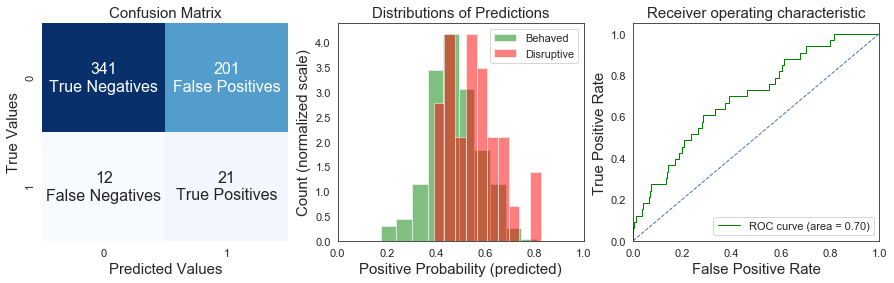

'Model F1 Score: 0.16'

In [38]:
x = df[['age_com_exp1', 'age_com_exp2', 'age_com_exp3', 'disability', 'meetStReqs', 'meetPhysReqs', 
        'tvTime','cpuTime', 'outdoorTime', 'gender_Female', 'gender_Male','mothersEdu_1',
        'mothersEdu_2', 'mothersEdu_3']]

lgrcv = linear_model.LogisticRegressionCV(cv=5, solver='liblinear', multi_class='ovr', class_weight={False:1,True:19})
lgrcv.fit(x,y)
evalClassifier(lgrcv,x,y)

In [39]:
#let's do the same for the activity measurements
df[['tvTime', 'cpuTime', 'outdoorTime']].corr()

,tvTime,cpuTime,outdoorTime
tvTime,1.000000,0.310639,0.281133
cpuTime,0.310639,1.000000,0.192238
outdoorTime,0.281133,0.192238,1.000000


In [40]:
pcacols = df[['tvTime', 'cpuTime', 'outdoorTime']].astype('float')
X = StandardScaler().fit_transform(pcacols)
eig_val_cov, eig_vec_cov = np.linalg.eig(np.cov(X.T))
print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.508566   0.22163603 0.26979798]


In [41]:
#Let's add all 3 components to the dataframe and see if it improves anything. 
#We don't really need the dimensionality reduction, but the reduced multicolinearity may help.

df['activities1'] = eig_vec_cov[:,0].T.dot(X.T)
df['activities2'] = eig_vec_cov[:,1].T.dot(X.T)
df['activities3'] = eig_vec_cov[:,2].T.dot(X.T)

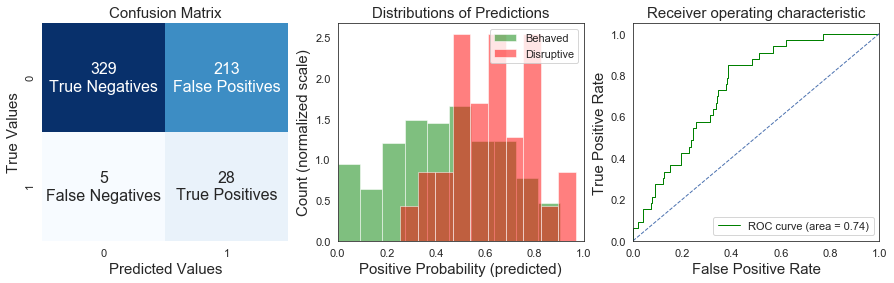

'Model F1 Score: 0.20'

In [42]:
x = df[['age_com_exp1', 'age_com_exp2', 'age_com_exp3', 'disability', 'meetStReqs', 'meetPhysReqs', 
        'activities1','activities2', 'activities3', 'gender_Female', 'gender_Male','mothersEdu_1',
        'mothersEdu_2', 'mothersEdu_3']]

lgrcv = linear_model.LogisticRegressionCV(cv=5, solver='liblinear', multi_class='ovr', class_weight={False:1,True:19})
lgrcv.fit(x,y)
evalClassifier(lgrcv,x,y)

----

# Boolean variables
Before digging into our boolean variables, let's simplify by combining the 2 smallest groups in Mother's Education into one, making it a true boolean field. The distributions below show that this can happen without much lost information.

Going forward, we will include only mothersEdu_3, which implicitly groups 1 and 2 together as the nullvalues of 3.

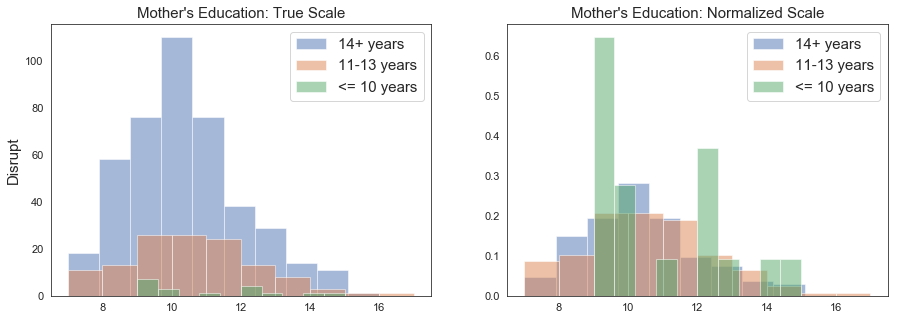

In [43]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.title('Mother\'s Education: True Scale')
plt.ylabel('Disrupt')
plt.hist(df[df.mothersEdu_3==1]['disrupt'], alpha=.5, label='14+ years')
plt.hist(df[df.mothersEdu_2==1]['disrupt'], alpha=.5, label='11-13 years')
plt.hist(df[df.mothersEdu_1==1]['disrupt'], alpha=.5, label='<= 10 years')
plt.legend(fontsize=15)
plt.subplot(122)
plt.title('Mother\'s Education: Normalized Scale')
plt.hist(df[df.mothersEdu_3==1]['disrupt'], alpha=.5, label='14+ years', density=True)
plt.hist(df[df.mothersEdu_2==1]['disrupt'], alpha=.5, label='11-13 years', density=True)
plt.hist(df[df.mothersEdu_1==1]['disrupt'], alpha=.5, label='<= 10 years', density=True)
plt.legend(fontsize=15)
plt.show()

# Sidebar: PCA with boolean (categorical one-hot encoded) variables

In [44]:

def ngraph(comp1,comp2, pca_labels=True, ncounts=True):
    '''Creates a simple scatter plot of two
    boolean variables that includes n-counts of
    the 4 clusters of overlapping points. This
    should really only be used on datasets with
    very finite permutations; pass ncounts=False
    for other types to avoid messy labels.'''
    
    #Round them for convenient labelling
    x=np.round(comp1,2)
    y=np.round(comp2,2)
    
    #The labels work by counting bins on an
    #implicit histogram for each axis.
    #set histogram bins to be neatly around the possible values
    xuniq = list(set(x))
    xuniq.sort()
    xedges = np.asarray([i+.5 for i in xuniq])
    xedges = np.insert(xedges,0,xuniq[0]-.5)
    yuniq = list(set(y))
    yuniq.sort()
    yedges = np.asarray([i+.5 for i in yuniq])
    yedges = np.insert(yedges,0,yuniq[0]-.5)
    bins=np.asarray([yedges,xedges])
    
    #Create 2D histogram for labels on each axis
    hist, xbins,ybins = np.histogram2d(y,x, bins=bins)
    #create meshgrid for label coordinates
    B,C = np.meshgrid(xuniq, yuniq)
    #Don't label zeroes in the histogram
    X = B[hist != 0]
    Y = C[hist != 0]
    Z   = hist[hist != 0]
    
    fig, ax = plt.subplots(figsize=[6,6])
    ax.scatter(x,y, s=100, alpha=0.4, marker='o', color='black')
    plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.gca().set_aspect('equal', adjustable='box')
    #Allows us to label components and features differently
    if pca_labels:
        plt.xlabel('First Component')
        plt.ylabel('Second Component')
    else:
        #print(inspect.getargvalues(ngraph))
        plt.xlabel('First Feature')
        plt.ylabel('Second Feature')
    plt.title('Simple Scatterplot')
    #Label the points to notate perfectly overlapping clusters:
    if ncounts:
        for i in range(len(Z)):
            ax.annotate(str(int(Z[i]))+" points", xy=(X[i],Y[i]), xytext=(10,-1), 
                        textcoords="offset points", fontsize=15, 
                        fontstyle='italic', color='grey')
    plt.show()
    

In [45]:
def explode(a,b, components=True):
    '''This unconventional function shows two arrays
    on numberlines, then "explodes" their values. 
    Its usefulness is largely for getting an idea
    of clustering going on when your data has a lot 
    of repeated values, as will happen when you
    create components from binary data.'''
    #color components and features differently
    if components:
        color1, color2 = 'green', 'purple'
    else:
        color1, color2 = 'red', 'blue'
    fig = plt.figure(figsize=[15,5])
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 8]) 
    ax1 = fig.add_subplot(gs[0])
    #Put the first array on a numberline
    ax1.scatter([0 for y in a],a, color=color1)
    if components:
        plt.xlabel('First Component')
    else:
        plt.xlabel('First Feature')
    plt.xticks([])
    
    #Put the second array on a numberline with the same
    #axis as the first
    ax2 = fig.add_subplot(gs[1], sharey=ax1)
    ax2.scatter([0 for y in b],b, color=color2)
    if components:
        plt.xlabel('Second Component')
    else:
        plt.xlabel('Second Feature')
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.xticks([])
    
    #Explode both arrays on the same axis
    ax3 = fig.add_subplot(gs[2], sharey=ax1)
    ax2.axis = ax1.axis
    ax3.plot(a, color=color1, marker='o', linestyle='None', alpha=.5)
    ax3.plot(b, color=color2, marker='o', linestyle='None', alpha=.5)
    if components:
        plt.xlabel('Components "exploded" for visualization')
    else:
        plt.xlabel('Features "exploded" for visualization')
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.xticks([])
    plt.show()
    

In [46]:
def explodePres(a,b, components=True):
    '''This function is the same as explode(),
    except with one added graph that is convenient
    #for my Capstone presentation, and can be ignored
    otherwise.'''
    if components:
        color1, color2 = 'green', 'purple'
    else:
        color1, color2 = 'red', 'blue'
    fig = plt.figure(figsize=[15,6])
    gs = gridspec.GridSpec(2, 3, width_ratios=[3, 1, 6], height_ratios=[5,1]) 
    ax1 = fig.add_subplot(gs[0])
    ax1.scatter([0 for y in a],a, color=color1)
    if components:
        plt.xlabel('First Component')
    else:
        plt.xlabel('First Feature')
    plt.xticks([])

    ax2 = fig.add_subplot(gs[1], sharey=ax1)
    ax2.scatter([0 for y in b],b, color=color2)
    if components:
        plt.xlabel('Second Component')
    else:
        plt.xlabel('Second Feature')
    #plt.setp(ax2.get_yticklabels(), visible=False)
    plt.xticks([])

    ax3 = fig.add_subplot(gs[2], sharey=ax1)
    ax2.axis = ax1.axis
    ax3.plot(a, color=color1, marker='o', linestyle='None', alpha=.5)
    ax3.plot(b, color=color2, marker='o', linestyle='None', alpha=.5)
    if components:
        plt.xlabel('Components "exploded" for visualization')
    else:
        plt.xlabel('Features "exploded" for visualization')
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.xticks([])
    
    ax4 = fig.add_subplot(gs[-1,0:2])
    ax4.scatter(a,[0 for _ in a], color=color1)
    if components:
        plt.xlabel('First Component')
    else:
        plt.xlabel('First Feature')
    plt.yticks([])
    plt.xticks(ax1.get_yticks())
    
    
    
    
    plt.show()

**Using simple, fake data to understand how this works before digging into the real data:**
Let's start with just 2 binary variables. 

In [47]:
fake = [
    [1.,0.,1.,1.,0.,0.,0.,1.,1.,1.,1.,1.,0.],
    [1.,0.,1.,1.,0.,0.,1.,0.,0.,0.,0.,0.,1.]
]
fake = pd.DataFrame(np.array(fake).T.tolist(),columns=['one','two'])
fake

,one,two
0,1.0,1.0
1,0.0,0.0
2,1.0,1.0
3,1.0,1.0
4,0.0,0.0
5,0.0,0.0
6,0.0,1.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


How would these look on a scatter plot? We'd expect just 4 clusters of points:

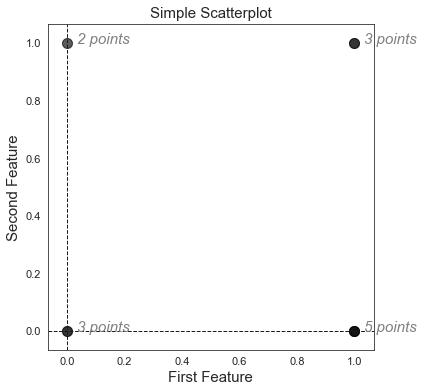

In [48]:
ngraph(fake.one, fake.two, pca_labels=False)

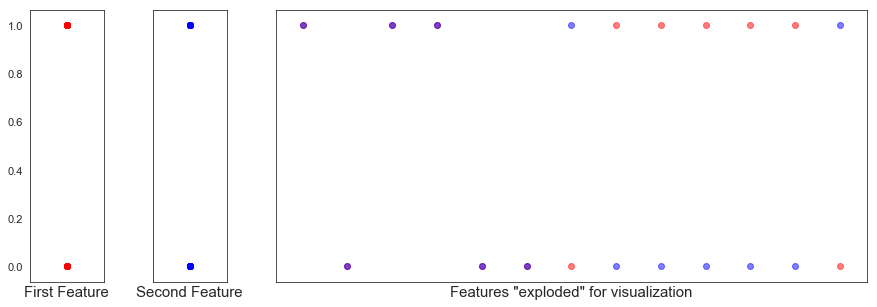

In [49]:
explode(fake.one, fake.two, components=False)

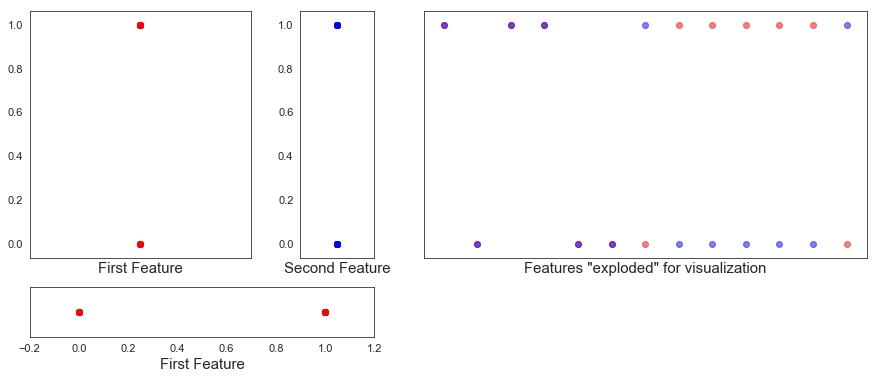

In [50]:
#This is for the PDF/Presentation
explodePres(fake.one, fake.two, components=False)

Suppose we ran PCA on just those two WITHOUT standard deviation scaling, and then plotted the two components - what would that look like?

We'd expect the first eigenvector to just be a line through whichever two points 

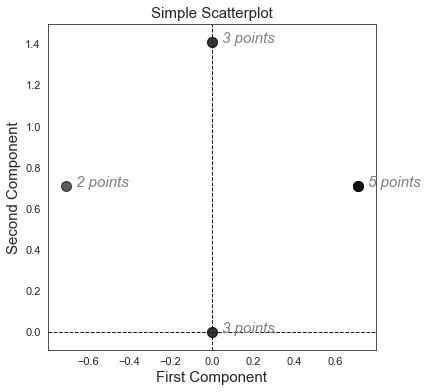

In [51]:
X = StandardScaler(with_mean=False, with_std=False).fit_transform(fake)
eig_val_cov, eig_vec_cov = np.linalg.eig(np.cov(X.T))
#Create the components in order of importance
ev_order = rankdata(eig_val_cov, method='ordinal')
eig_vec_cov = np.asarray([eig_vec_cov[i-1] for i in np.flip(ev_order)])
comp1 = eig_vec_cov[:,0].T.dot(X.T)
comp2 = eig_vec_cov[:,1].T.dot(X.T)
ngraph(comp1, comp2)

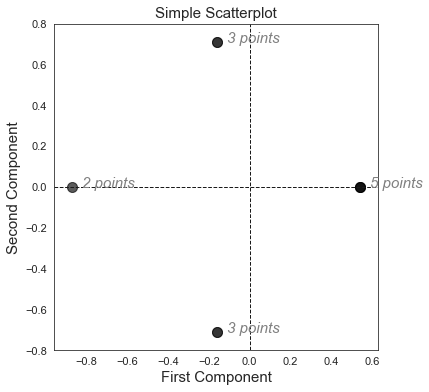

In [52]:
#However, with scaling it's not so neat:
X = StandardScaler(with_mean=True, with_std=False).fit_transform(fake)
eig_val_cov, eig_vec_cov = np.linalg.eig(np.cov(X.T))
#Create the components in order of importance
ev_order = rankdata(eig_val_cov, method='ordinal')
eig_vec_cov = np.asarray([eig_vec_cov[i-1] for i in np.flip(ev_order)])
comp1 = eig_vec_cov[:,0].T.dot(X.T)
comp2 = eig_vec_cov[:,1].T.dot(X.T)

ngraph(comp1, comp2)

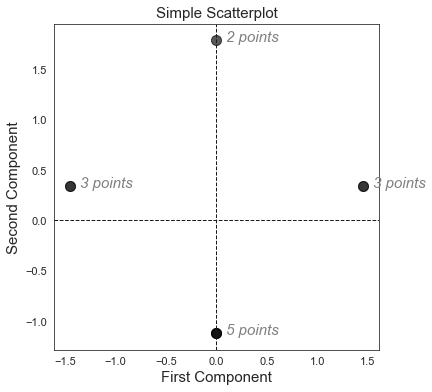

In [53]:
X = StandardScaler(with_mean=True, with_std=True).fit_transform(fake)
eig_val_cov, eig_vec_cov = np.linalg.eig(np.cov(X.T))
#Create the components in order of importance
ev_order = rankdata(eig_val_cov, method='ordinal')
eig_vec_cov = np.asarray([eig_vec_cov[i-1] for i in np.flip(ev_order)])
comp1 = eig_vec_cov[:,0].T.dot(X.T)
comp2 = eig_vec_cov[:,1].T.dot(X.T)

ngraph(comp1, comp2)

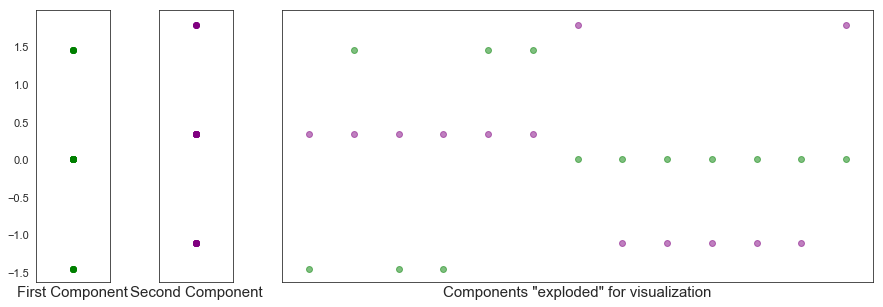

In [54]:
explode(comp1, comp2)

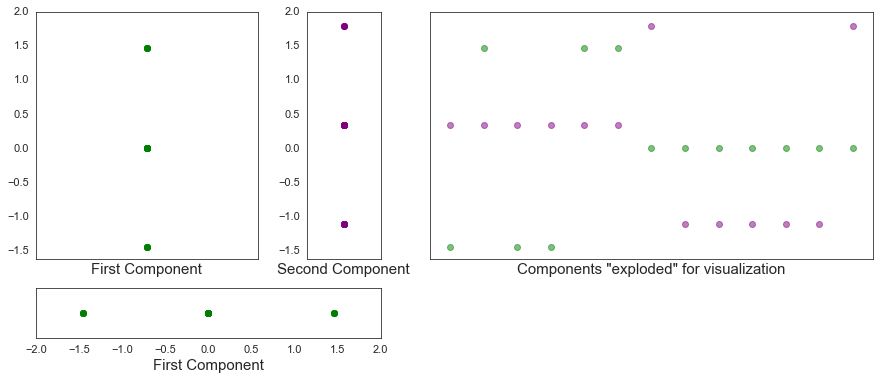

In [55]:
#This is for the PDF/Presentation
explodePres(comp1, comp2)

# Back to our Data

In [56]:
df.columns

Index(['ID', 'age', 'disability', 'allSocialSkills', 'express', 'comply',
       'disrupt', 'meetStReqs', 'meetPhysReqs', 'screenTime', 'tvTime',
       'cpuTime', 'outdoorTime', 'gender_Female', 'gender_Male',
       'mothersEdu_1', 'mothersEdu_2', 'mothersEdu_3', 'ytrans',
       'age_com_exp1', 'age_com_exp2', 'age_com_exp3', 'activities1',
       'activities2', 'activities3'],
      dtype='object')

In [57]:
pcacols = df[['disability', 'meetStReqs', 'meetPhysReqs', 'gender_Male', 'mothersEdu_3']].astype('float')

#create a couple more binary features:

pcacols['bothSTabovemean'] = (df.tvTime < np.mean(df.tvTime)) & (df.cpuTime > np.mean(df.cpuTime))
expressM = np.mean(df.express)
pcacols['expressive'] = df.express > expressM
complyM = np.mean(df.comply)
pcacols['compliant'] = df.comply > complyM


X = StandardScaler().fit_transform(pcacols)
eig_val_cov, eig_vec_cov = np.linalg.eig(np.cov(X.T))
print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

The percentage of total variance in the dataset explained by each component calculated by hand.
 [0.18212952 0.15871679 0.07939322 0.11436226 0.09492538 0.09971197
 0.13671288 0.13404797]


c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [58]:
#Add all components back to the dataframe
for i in range(len(pcacols.columns)):
    df['binComp'+str(i+1)] = eig_vec_cov[:,i].T.dot(X.T)

In [59]:
#for the sake of graphing:
pcacols['comp1']= eig_vec_cov[:,0].T.dot(X.T)
pcacols['comp2'] = eig_vec_cov[:,1].T.dot(X.T)

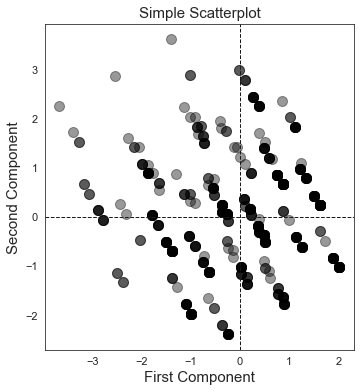

In [60]:
ngraph(pcacols.comp1, pcacols.comp2, ncounts=False)

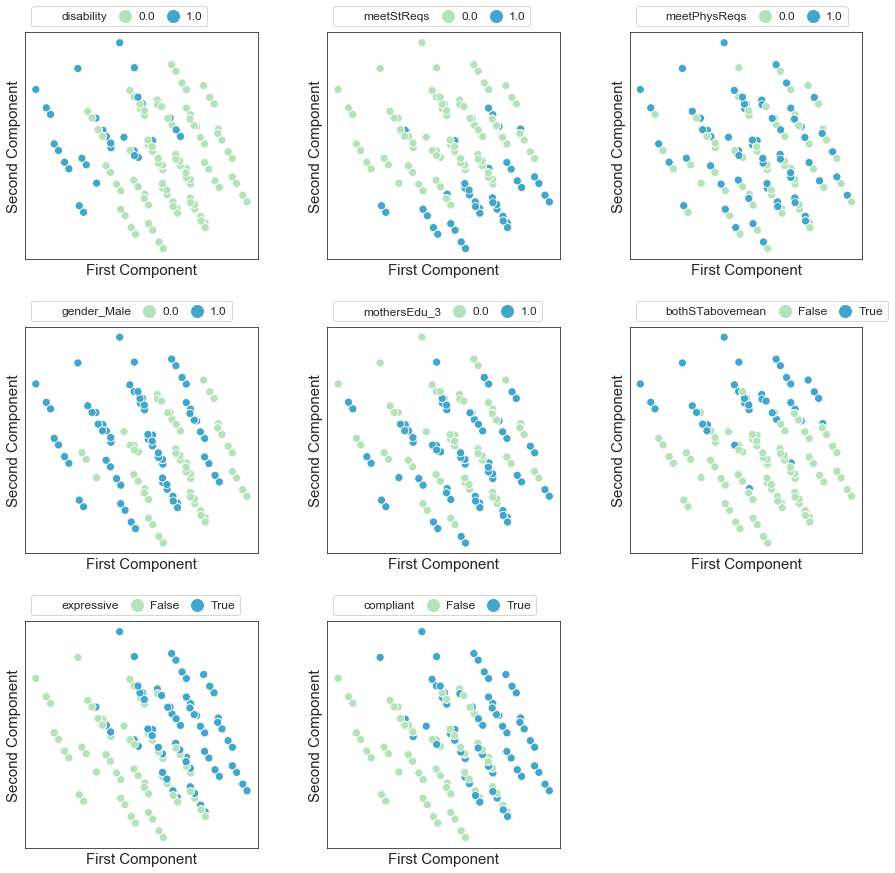

In [61]:
fig= plt.figure(figsize=[15,15])
sns.set_style("white")
sns.set_style("ticks")
for i,col in enumerate(pcacols.columns[:8]):
    fig.add_subplot(3,3,i+1)
    g =sns.scatterplot(x='comp1', y='comp2', hue=col, data=pcacols,
            s=65, marker='o', legend='brief', palette='GnBu')
    g.legend(loc='lower left',bbox_to_anchor=(0, 1), ncol=3, markerscale=2, columnspacing=.5, handletextpad=.1, fontsize=12)
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=.3, hspace=.3)
plt.show()

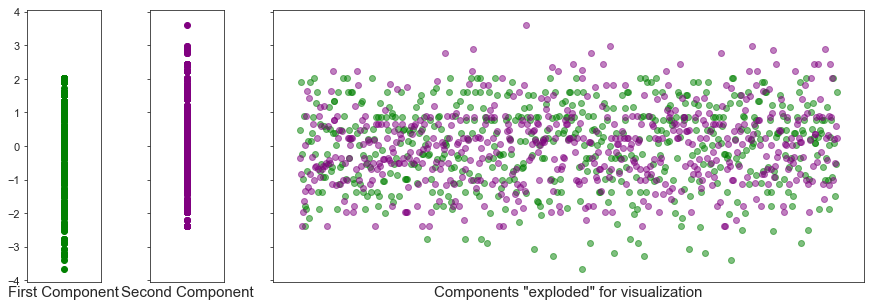

In [62]:
explode(pcacols.comp1, pcacols.comp2)

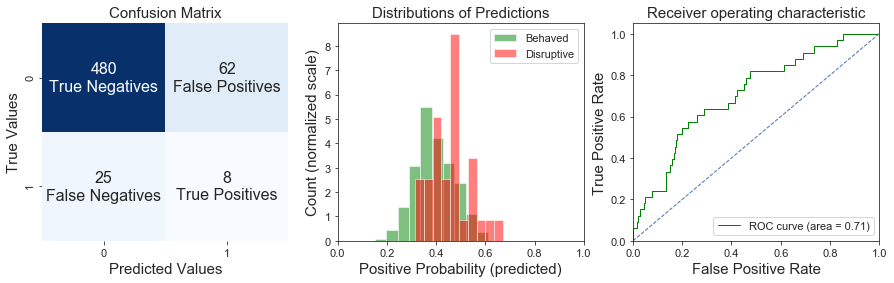

'Model F1 Score: 0.16'

In [63]:
x = df[['age_com_exp1', 'age_com_exp2', 'age_com_exp3', 'activities1','activities2', 'activities3', 
        'binComp1', 'binComp2', 'binComp3','binComp4', 'binComp5', 'binComp6', 'binComp7']]

lgrcv = linear_model.LogisticRegressionCV(cv=5, solver='liblinear', multi_class='ovr', class_weight={False:1,True:8})
lgrcv.fit(x,y)
evalClassifier(lgrcv,x,y)

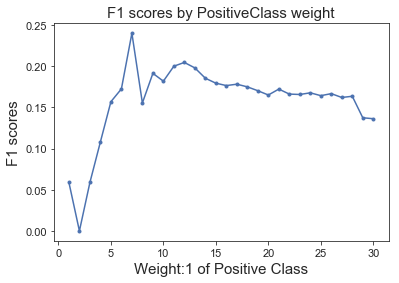

In [64]:
#Let's check weights again
weights = list(range(1,31))
F1scores = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in weights:
        lgrcv = linear_model.LogisticRegressionCV(
            cv=5, solver='liblinear', multi_class='ovr',class_weight = {False:1,True:i})
        lgrcv.fit(x,y)
        cm = confusion_matrix(y,lgrcv.predict(x))
        tn, fp, fn, tp = [i for i in cm.ravel()]
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = 2*(precision * recall) / (precision + recall)
        if np.isnan(F1):
            F1 = 0
        F1scores.append(F1)
plt.plot(weights, F1scores, 'b.-')
plt.title('F1 scores by PositiveClass weight')
plt.xlabel('Weight:1 of Positive Class')
plt.ylabel('F1 scores')
plt.show()

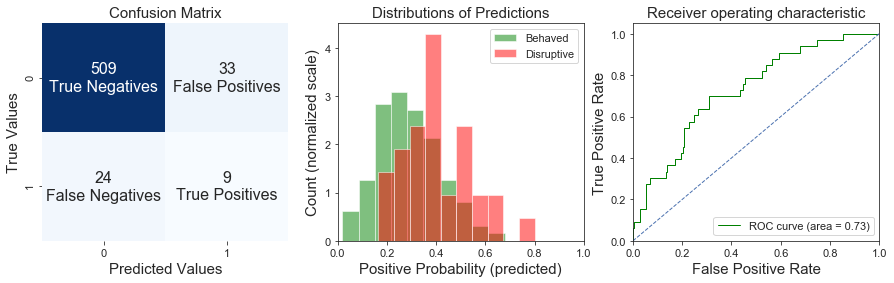

'Model F1 Score: 0.24'

In [65]:
x = df[['age_com_exp1', 'age_com_exp2', 'age_com_exp3', 'activities1','activities2', 'activities3', 
        'binComp1', 'binComp2', 'binComp3','binComp4', 'binComp5', 'binComp6']]
lgrcv = linear_model.LogisticRegressionCV(cv=5, solver='liblinear', multi_class='ovr', class_weight={False:1,True:7})
lgrcv.fit(x,y)
evalClassifier(lgrcv,x,y)

| Logistic Regressor Summary | n Features | Class Weights | F1Score | AUC |
|----------------------------|------------|---------------|---------|-----|
| Basic | 15 | 1:1 | .06 | .73 |
| Balanced | 15 | 1:16 | .12 | .65 |
| "Optimized" Weights | 15 | 1:19 | .20 | .74 |
| Ridge | 15 | 1:19 | .20 | .74 |
| With continuous components | 14 | 1:19 | .20 | .74 |
| With cont & binary components | 12 | 1:7 | .24 | .73 |